In [74]:
import json
import os
import torch


### GET LINEAR EVAL RESULTS ###

#method_names = ['btwins', 'dc', 'moco', 'simsiam', 'sup', 'swav']
dataset_names = ['Aircraft', 'Cars', 'CUB', 'Dogs', 'Flowers', 'NABirds', 'ImageNet']
vissl_dir = '/vulcanscratch/mgwillia/vissl'
results = {}
for dataset in dataset_names:
    ## TODO: eventually, compare top-1 to top-5
    results[dataset.lower()] = {}
    for results_folder in os.listdir(vissl_dir):
        if f'chkpts_b_{dataset.lower()}' not in results_folder:
            continue
        if 'metrics.json' not in os.listdir(os.path.join(vissl_dir, results_folder)):
            continue
        method_name = results_folder.split('_')[3]
        if len(results_folder.split('_')) == 4:
            idx = 0
        else:
            continue
            #idx = int(results_folder.split('_')[4])
        if method_name not in results[dataset.lower()]:
            results[dataset.lower()][method_name] = {
                'train': {},
                'val': {}
            }
        #print(os.path.join(vissl_dir, results_folder, 'metrics.json'))
        with open(os.path.join(vissl_dir, results_folder, 'metrics.json'), 'r') as read_file:
            for line in read_file.readlines():
                json_line = json.loads(line)
                if 'train_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['train_accuracy_list_meter']['top_1'].items():
                        if key not in results[dataset.lower()][method_name]['train']:
                            results[dataset.lower()][method_name]['train'][key] = []
                        results[dataset.lower()][method_name]['train'][key].append(value)
                elif 'test_accuracy_list_meter' in json_line.keys():
                    for key, value in json_line['test_accuracy_list_meter']['top_1'].items():
                        if key not in results[dataset.lower()][method_name]['val']:
                            results[dataset.lower()][method_name]['val'][key] = []
                        results[dataset.lower()][method_name]['val'][key].append(value)
linear_results = results['imagenet'].copy()
linear_results_fgvc = results['aircraft'].copy()


### GET KNN RESULTS ###

outfile_root = '/cfarhomes/mgwillia/unsupervised-analysis/outfiles/'

fgvc_datasets = ['aircraft', 'cars', 'cub', 'dogs', 'flowers', 'nabirds']
results = {}
for dataset_name in fgvc_datasets:
    results[dataset_name] = {}
results['imagenet'] = {}

for file_name in os.listdir(outfile_root):
    if 'knn_' not in file_name:
        continue
    dataset_name = file_name.split('_')[1].split('.')[0].replace('inet', 'imagenet')
    with open(os.path.join(outfile_root, file_name), 'r') as read_file:
        lines = read_file.readlines()
        if dataset_name == 'imagenet':
            for line in lines:
                if 'backbone' in line:
                    method_name = line.split(' ')[7][:-1]
                    if method_name not in results[dataset_name]:
                        results[dataset_name][method_name] = {}
                if 'Top1' in line:
                    top1 = float(line.split(' ')[4][:-1])
                    top5 = float(line.strip().split(' ')[6])
                    results[dataset_name][method_name]['top1'] = top1
                    results[dataset_name][method_name]['top5'] = top5
        else:
            for line in lines[1:]:
                stripped_line = line.strip()
                method_name = stripped_line.split(' ')[1][:-1]
                if method_name not in results[dataset_name]:
                        results[dataset_name][method_name] = {}
                num_neighbors = int(stripped_line.split(' ')[10][:-1])
                results[dataset_name][method_name][num_neighbors] = {}
                top1 = float(stripped_line.split(' ')[-3][:-1])
                top5 = float(stripped_line.strip().split(' ')[-1])
                results[dataset_name][method_name][num_neighbors]['top1'] = top1
                results[dataset_name][method_name][num_neighbors]['top5'] = top5
knn_results = results['imagenet'].copy()


### GET KMEANS RESULTS ###

model_accuracies = torch.load('kmeans_results.pth.tar')
results = {}
results['imagenet'] = {}
for method_name, accuracies in model_accuracies.items():
    results['imagenet'][method_name] = accuracies[-1]
kmeans_results = results['imagenet'].copy()

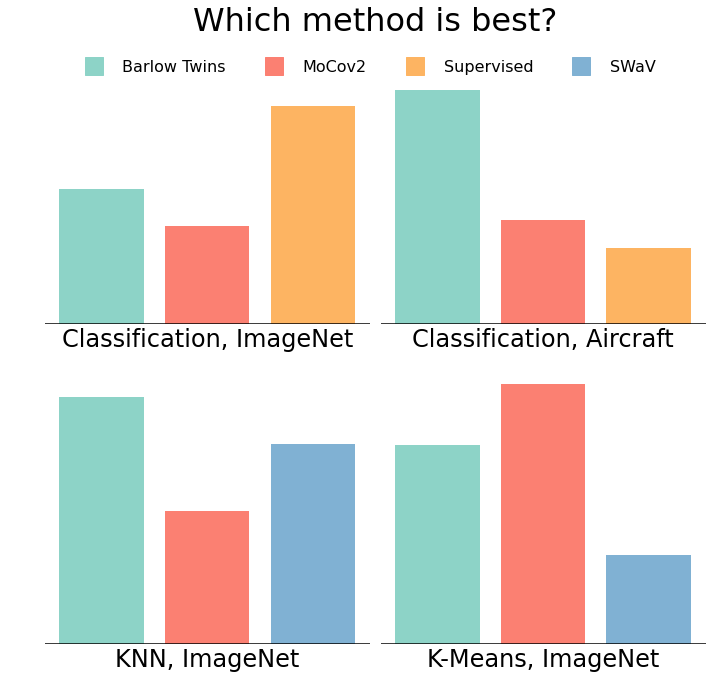

In [133]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
cmap = plt.get_cmap('Set3')
colormap = np.array(list(cmap.colors))


#### PREP RESULTS ####

#teaser_method_names = ['btwins', 'dc', 'moco', 'sup']
teaser_method_names = ['btwins', 'moco', 'sup']

teaser_linear_results = {}
for method_name in teaser_method_names:
    teaser_linear_results[method_name] = linear_results[method_name]['val']['res5'][-1]
    
teaser_linear_results_fgvc = {}
for method_name in teaser_method_names:
    teaser_linear_results_fgvc[method_name] = linear_results_fgvc[method_name]['val']['res5'][-1]

#teaser_method_names = ['btwins', 'dc', 'moco', 'swav']
teaser_method_names = ['btwins', 'moco', 'swav']
#method_names = ['btwins_r50_1000', 'dcv2_r50_800', 'moco_r50_800', 'swav_r50_800']
method_names = ['btwins_r50_1000', 'moco_r50_800', 'swav_r50_800']

teaser_knn_results = {}
for i, method_name in enumerate(method_names):
    teaser_knn_results[teaser_method_names[i]] = knn_results[method_name]['top1']

teaser_kmeans_results = {}
for i, method_name in enumerate(method_names):
    teaser_kmeans_results[teaser_method_names[i]] = kmeans_results[method_name] * 100
    
#print(teaser_linear_results)
#print(teaser_linear_results_fgvc)
#print(teaser_knn_results)
#print(teaser_kmeans_results)


#### MAKE FIGURE ####

#method_names_sup = ['btwins', 'dc', 'moco', 'sup']
method_names_sup = ['btwins', 'moco', 'sup']
#method_names_sim = ['btwins', 'dc', 'moco', 'swav']
method_names_sim = ['btwins', 'moco', 'swav']
method_ids_sup = [0, 3, 5]
method_ids_sim = [0, 3, 4]
method_ids = [0, 3, 5, 4]

fig, axs = plt.subplots(2, 2)

#axs[0, 0].bar([1, 2, 3, 4], list(teaser_linear_results.values()), color=colormap[method_ids_sup])
axs[0, 0].bar([1, 2, 3], list(teaser_linear_results.values()), color=colormap[method_ids_sup])
axs[0, 0].set_ylim(min(list(teaser_linear_results.values())) - 5, max(list(teaser_linear_results.values())) + 3.5)
axs[0, 0].axhline(y=min(list(teaser_linear_results.values())) - 5, color='black', linestyle='-')

#axs[0, 1].bar([1, 2, 3, 4], list(teaser_linear_results_fgvc.values()), color=colormap[method_ids_sup])
axs[0, 1].bar([1, 2, 3], list(teaser_linear_results_fgvc.values()), color=colormap[method_ids_sup])
axs[0, 1].set_ylim(min(list(teaser_linear_results_fgvc.values())) - 5, max(list(teaser_linear_results_fgvc.values())) + 3.5)
axs[0, 1].axhline(y=min(list(teaser_linear_results_fgvc.values())) - 5, color='black', linestyle='-')

#axs[1, 0].bar([1, 2, 3, 4], list(teaser_knn_results.values()), color=colormap[method_ids_sim])
axs[1, 0].bar([1, 2, 3], list(teaser_knn_results.values()), color=colormap[method_ids_sim])
axs[1, 0].set_ylim(min(list(teaser_knn_results.values())) - 5, max(list(teaser_knn_results.values())) + 1.5)
axs[1, 0].axhline(y=min(list(teaser_knn_results.values())) - 5, color='black', linestyle='-')

#axs[1, 1].bar([1, 2, 3, 4], list(teaser_kmeans_results.values()), color=colormap[method_ids_sim])
axs[1, 1].bar([1, 2, 3], list(teaser_kmeans_results.values()), color=colormap[method_ids_sim])
axs[1, 1].set_ylim(min(list(teaser_kmeans_results.values())) - 5, max(list(teaser_kmeans_results.values())) + 1.5)
axs[1, 1].axhline(y=min(list(teaser_kmeans_results.values())) - 5, color='black', linestyle='-')

axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])
axs[1, 0].set_xticks([])
axs[1, 1].set_xticks([])

axs[0, 0].set_title('Classification, ImageNet', fontsize=24, y=-0.1)
axs[0, 1].set_title('Classification, Aircraft', fontsize=24, y=-0.1)
axs[1, 0].set_title('KNN, ImageNet', fontsize=24, y=-0.1)
axs[1, 1].set_title('K-Means, ImageNet', fontsize=24, y=-0.1)

axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')
axs[1, 1].axis('off')

#ax.set_xticks(0.5 + np.array(list(range(3, len(dataset_names) * 7 + 3, 7))))
#ax.set_xticklabels(dataset_names, fontsize=14)
#ax.tick_params(axis='both', which='major', labelsize=14)
#ax.tick_params(axis='both', which='minor', labelsize=14)
#ax.axhline(y=0.0, color='gray', linestyle='--')
    
#f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
#handles = [f("s", colormap[i]) for i in method_ids]
#ax.legend(handles,
#          method_names,
#          title='Method',
#          title_fontsize=18,
#          scatterpoints=1,
#          ncol=2,
#          fontsize=18)

#ax.set_ylabel('Accuracy (% difference from supervised)', fontsize=20)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.title('Which method is best?', fontsize=32)
f = lambda m,c: plt.plot([],[],marker=m, markersize=18, color=c, ls="none")[0]
handles = [f("s", colormap[i]) for i in method_ids]
fig.legend(handles,
          ['Barlow Twins', 'MoCov2', 'Supervised', 'SWaV'],
          #['Barlow Twins', 'DeepClusterv2', 'MoCov2', 'SWaV', 'Supervised'],
          #ncol=5,
          ncol=4,
          fontsize=16,
          #loc='lower center'), 
          loc=(0.1, 0.88), 
          frameon=False)  

fig.tight_layout()
fig.subplots_adjust(bottom=0.1) 
plt.savefig('teaser_square', bbox_inches = 'tight', pad_inches = 0.1)